In [1]:
#Import the relevant packages:
import torch
import numpy as np, cv2, pandas as pd, glob, time
import matplotlib.pyplot as plt

%matplotlib inline
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision

from torchvision import transforms, models, datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os

import cv2

In [2]:
# upload our Kaggle authentication file
! pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600 ~/.kaggle/kaggle.json

In [7]:
# download the cats and dogs dataset and unzip it
! kaggle datasets download jangedoo/utkface-new

 98% 324M/331M [00:01<00:00, 192MB/s]
100% 331M/331M [00:01<00:00, 181MB/s]


In [8]:
! unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [9]:
path = "/content/utkface_aligned_cropped/UTKFace"

In [10]:
files = os.listdir(path)

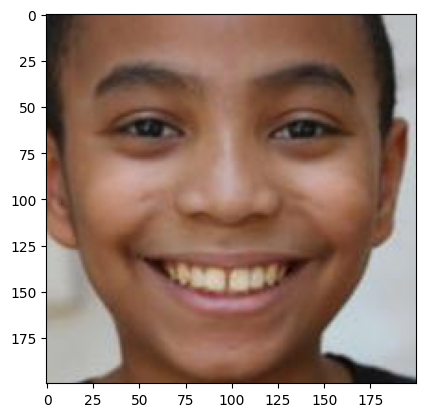

In [11]:
img = cv2.imread("/content/utkface_aligned_cropped/UTKFace/10_0_1_20170110220507258.jpg.chip.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [12]:
images=[]
ages=[]
gender=[]

for file in files:

    images.append(file)
    imgname = file.split("_")

    ages.append(int(imgname[0]))
    gender.append(int(imgname[1]))

In [13]:
df = pd.DataFrame({"images": images , "ages":ages , "gender":gender } )
df.head()

,images,ages,gender
0,26_0_0_20170116182305836.jpg.chip.jpg,26,0
1,50_1_0_20170117174644414.jpg.chip.jpg,50,1
2,26_0_3_20170119192402842.jpg.chip.jpg,26,0
3,7_1_1_20170112210604630.jpg.chip.jpg,7,1
4,26_0_1_20170117195923557.jpg.chip.jpg,26,0


In [14]:
train_df=df.sample(frac=1,random_state=0).iloc[:18000]
test_df=df.sample(frac=1,random_state=0).iloc[18000:]

In [15]:
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dir = '/content/Training'
val_dir = '/content/Validation'

train_datasets = (datasets.ImageFolder(os.path.join(train_df), transforms_train))
val_datasets = (datasets.ImageFolder(os.path.join(test_df), transforms_val))

TypeError: ignored

In [ ]:
len(train_df)

In [ ]:
len(test_df)

In [ ]:
train_loader = DataLoader(ttrain_datasets, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(val_datasets, batch_size=32)

In [ ]:
def get_model():
    model = models.vgg16(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)